In [215]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import scipy.stats as stats

In [203]:
t1 = pd.DataFrame({"f1":[1,2,5,None]})
t2 = pd.DataFrame({"f1":[1,2,2,None]})


In [211]:
res = pd.merge(t1, t2, how='right', on='f1')
res

,f1
0,1.0
1,2.0
2,2.0
3,NaN


# A/B - тестирование

Считываем  сsv-файлы в три DataFrame и смотрим: типы данных в таблицах, есть ли пропущенные данные.

In [174]:
df1 = pd.read_csv('active_studs.csv')

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [23]:
df1.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [11]:
df2 = pd.read_csv('checks.csv',sep=';')

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [29]:
df2['rev'].agg({'min','max','median'})

median     840.0
max       4650.0
min        199.0
Name: rev, dtype: float64

In [47]:
df3 = pd.read_csv('groups.csv',skiprows=1,sep=';', names=['student_id','group'])

In [48]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   student_id  74576 non-null  int64 
 1   group       74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [49]:
df3.head()

,student_id,group
0,1206794,B
1,331024,B
2,1733498,A
3,161574,B
4,168443,B


Все ок. Соединяем три таблицы в одну: active_studs <- groups <- checks. Заменяем null на 0 в столбце с оплатами, проверяем, что нет активных пользователей без группы.

In [232]:
data = pd.merge(df1, df3, how='left', on=['student_id', 'student_id'])
data1 = pd.merge(data, df2, how='left', on=['student_id', 'student_id'])
data1.fillna(0, inplace = True)
data3.group.unique()

array(['B', 'A'], dtype=object)

In [64]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8341 non-null   int64  
 1   group       8341 non-null   object 
 2   rev         8341 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 260.7+ KB


In [235]:
data3 = pd.merge(df3, df1, how='left', on=['student_id', 'student_id'])

In [233]:
#data3.info()

In [253]:
#data3.group.unique()

array(['B', 'A'], dtype=object)

In [236]:
total_count_b, total_count_a = df3['group'].value_counts()

In [237]:
count_b, count_a = data1['group'].value_counts()

In [238]:
cor_a, cor_b = count_a/total_count_a, count_b/total_count_b
print('Kонверсия в покупку в контрольной группе = ', cor_a)
print('Kонверсия в покупку в тестовой группе = ', cor_b)

Kонверсия в покупку в контрольной группе =  0.10467569590961683
Kонверсия в покупку в тестовой группе =  0.11360486281582419


In [221]:
ex_a = data1[(data1['group'] == 'A') & (data1['rev'] != 0)]['rev'].tolist()
ex_b = data1[(data1['group'] == 'B') & (data1['rev'] != 0)]['rev'].tolist()

314

In [166]:
fig = go.Figure(go.Funnel(
    y = ["Control_group_A","Visit", "Success_pay"],
    x = [len(df3[df3['group'] == 'A']),len(data1[data1['group'] == 'A']), len(ex_a)],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["darkblue", "blue", "skyblue"]}))
fig.show()

Построили воронку для котрольной группы А по трем группам: 1)пользователи из группы А, 2)посетившие платформу и 3)оплатившие товар.
То же самое проделали для тестовой группы В.
##### Получили следующие конверсии:
Из группы А посетили платформу только 10.5% пользователей, а из группы В - 11.4% пользователей.
В группе А решились оплатить заказ 5.1%, в группе В - 4.6%. От общего числа пользователей для каждой группы это составляет 0.5%
### Вывод:
Между новой и старой механикой ощутимой разницы нет: доля покупателей осталась прежней. 
Поэтому далее смотрим, повлияла ли новая механика на размер оплаты пользователей.

In [168]:
fig = go.Figure(go.Funnel(
    y = ["Test_group_B","Visit", "Success_pay"],
    x = [len(df3[df3['group'] == 'B']),len(data1[data1['group'] == 'B']), len(ex_b)],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["darkblue", "blue", "skyblue"]}))
fig.show()

## Проверка гипотез

Возьмем две выборки с оплатами контрольной группы А и тестовой группы В.
Сформулируем нулевую и альтернативную гипотезы для этих групп:

* H0 - нет значимой разницы между значениями оплат в группах;
* H1 - есть значимая разница между оплатами в группах.


Text(0.5, 1.0, 'test')

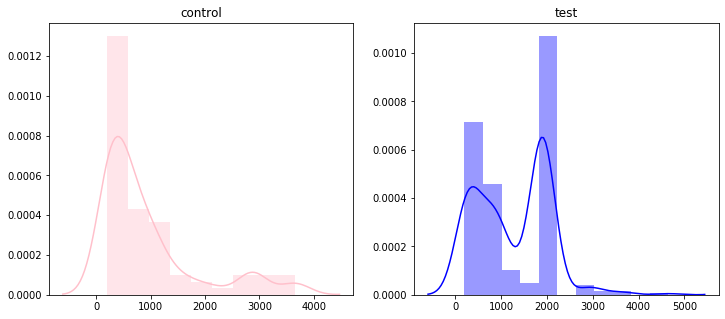

In [213]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(ex_a,color = 'pink',hist = True,ax = ax)
ax.set_title('control')

ax=f.add_subplot(122)
sns.distplot(ex_b,color = 'blue',hist = True,ax=ax)
ax.set_title('test')

**Проверим данные на нормальность**

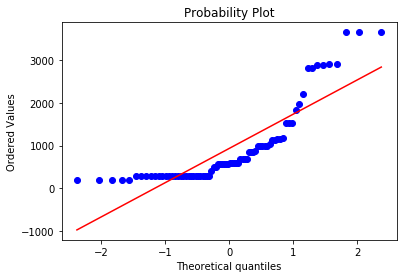

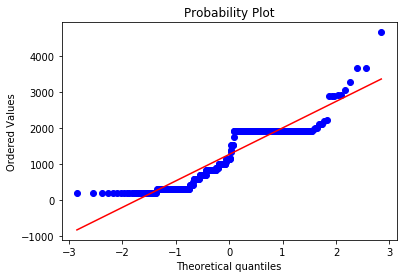

In [217]:
stats.probplot(ex_a, dist="norm", plot=plt)
plt.show()

stats.probplot(ex_b, dist="norm", plot=plt)
plt.show()

Оплаты распределены не нормально, группы у нас независимы, поэтому можем использовать непараметрический критерий Манна-Уитни.
Уровень значимости возьмем 0.05, двусторонняя критическая область:

In [243]:
stat, p_val = stats.mannwhitneyu(ex_a,ex_b,alternative = 'two-sided')
if p_val > 0.05:
    print('Статистически значимой разницы нет','\np-value',round(p_val,4),'\nU-критерий',stat)
else:
    print('Разница статистически значима','\np-value',round(p_val,4),'\nU-критерий',stat)

Разница статистически значима 
p-value 0.0003 
U-критерий 9001.0


**Значит, отвергаем нулевую гипотезу!**

Что будет, если возьмем правостороннюю критическую область?
Тогда:

* H0 - нет значимой разницы между значениями оплат в группах;
* H1 - средняя оплата в тестовой группе больше чем в контрольной группе.


In [250]:
stat, p_val = stats.mannwhitneyu(ex_a,ex_b,alternative = 'less')
if p_val > 0.05:
    print('Статистически значимой разницы нет','\np-value',round(p_val,4),'\nU-критерий',stat)
else:
    print('Разница статистически значима','\np-value',round(p_val,4),'\nU-критерий',stat)

Разница статистически значима 
p-value 0.0001 
U-критерий 9001.0


### Вывод:
С введением новой механики пользоватили страли тратить меньше, чем обычно. Возможно, новая механика вызвала недоверие у пользователей, поэтому они не спешат тратить большую сумму или воздерживаются от покупки более дорогого товара.

In [249]:
np.mean(ex_a)
np.mean(ex_b)

1257.8789920382164

In [251]:
np.sum(ex_a)

72820.0

In [252]:
np.sum(ex_b)

394974.0035